# Prediksi Harga rumah dengan LINEAR REGRESSION


## Data Set

TContent
HARGA RUMAH JAKSEL
Dataset harga rumah jaksel terdiri dari 7 kolom dengan jumlah data yaitu 1000 data. Kolom tersebut terdiri dari :

HARGA : harga dari rumah.
LT : jumlah luas tanah.
LB : jumlah luas bangunan.
JKT : jumlah kamar tidur.
JKM : jumlah kamar mandi.
GRS : ada/tidak ada
KOTA : nama kota.
DATA RUMAH
Dataset harga rumah tebet terdiri dari 8 kolom dengan jumlah data 1100 data. Kolom tersebut terdiri dari :

NO : nomor data.
NAMA RUMAH : title rumah.
HARGA : harga dari rumah.
LB : jumlah luas bangunan.
LT : jumlah luas tanah.
KT : jumlah kamar tidur.
KM : jumlah kamar mandi.
GRS : jumlah kapasitas mobil dalam garasi.
Acknowledgements
Terimakasih kepada Rumah123.com sebagai website tempat penjualan rumah/properti.


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [4]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9856ce14df5faa5762ea527d3e0950ff2d496984e6c9d65fcecbad2d3563b5d7
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Creating the Spark Session

In [10]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-prediksi rumah").getOrCreate()

In [11]:
spark

In [12]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-prediksi rumah>

In [13]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## 3. Load The Data From a File Into a Dataframe

In [14]:
HOUSING_DATA = 'DATA RUMAH.CSV'

Specifying the schema when loading data into a DataFrame will give better performance than schema inference.

In [15]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("HARGA", FloatType(), nullable=True),
    StructField("LB", FloatType(), nullable=True),
    StructField("LT", FloatType(), nullable=True),
    StructField("KT", FloatType(), nullable=True),
    StructField("KM", FloatType(), nullable=True),
    StructField("GRS", FloatType(), nullable=True),
    ]
)

In [18]:
# Load housing data
housing_df = spark.read.csv(path='DATA RUMAH.csv', schema=schema).cache()

In [19]:
# Inspect first five rows
housing_df.take(5)

[Row(HARGA=None, LB=None, LT=None, KT=None, KM=None, GRS=None),
 Row(HARGA=1.0, LB=None, LT=3800000000.0, KT=220.0, KM=220.0, GRS=3.0),
 Row(HARGA=2.0, LB=None, LT=4600000000.0, KT=180.0, KM=137.0, GRS=4.0),
 Row(HARGA=3.0, LB=None, LT=3000000000.0, KT=267.0, KM=250.0, GRS=4.0),
 Row(HARGA=4.0, LB=None, LT=430000000.0, KT=40.0, KM=25.0, GRS=2.0)]

In [20]:
# Show first five rows
housing_df.show(5)

+-----+----+-----+-----+-----+----+
|HARGA|  LB|   LT|   KT|   KM| GRS|
+-----+----+-----+-----+-----+----+
| NULL|NULL| NULL| NULL| NULL|NULL|
|  1.0|NULL|3.8E9|220.0|220.0| 3.0|
|  2.0|NULL|4.6E9|180.0|137.0| 4.0|
|  3.0|NULL|3.0E9|267.0|250.0| 4.0|
|  4.0|NULL|4.3E8| 40.0| 25.0| 2.0|
+-----+----+-----+-----+-----+----+
only showing top 5 rows



In [21]:
# show the dataframe columns
housing_df.columns

['HARGA', 'LB', 'LT', 'KT', 'KM', 'GRS']

In [22]:
# show the schema of the dataframe
housing_df.printSchema()

root
 |-- HARGA: float (nullable = true)
 |-- LB: float (nullable = true)
 |-- LT: float (nullable = true)
 |-- KT: float (nullable = true)
 |-- KM: float (nullable = true)
 |-- GRS: float (nullable = true)



## 4. Data Exploration

In [23]:
# run a sample selection
housing_df.select('KT','KM').show(10)

+-----+-----+
|   KT|   KM|
+-----+-----+
| NULL| NULL|
|220.0|220.0|
|180.0|137.0|
|267.0|250.0|
| 40.0| 25.0|
|400.0|355.0|
|300.0|154.0|
|120.0|150.0|
|350.0|247.0|
|125.0| 90.0|
+-----+-----+
only showing top 10 rows



### 4.1 Distribution of the median age of the people living in the area:

In [25]:
# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("GRS").count().sort("GRS", ascending=False)

In [26]:
result_df.show(10)

+----+-----+
| GRS|count|
+----+-----+
|10.0|   11|
| 9.0|   19|
| 8.0|   40|
| 7.0|   52|
| 6.0|   94|
| 5.0|  270|
| 4.0|  295|
| 3.0|  198|
| 2.0|   31|
|NULL|    1|
+----+-----+



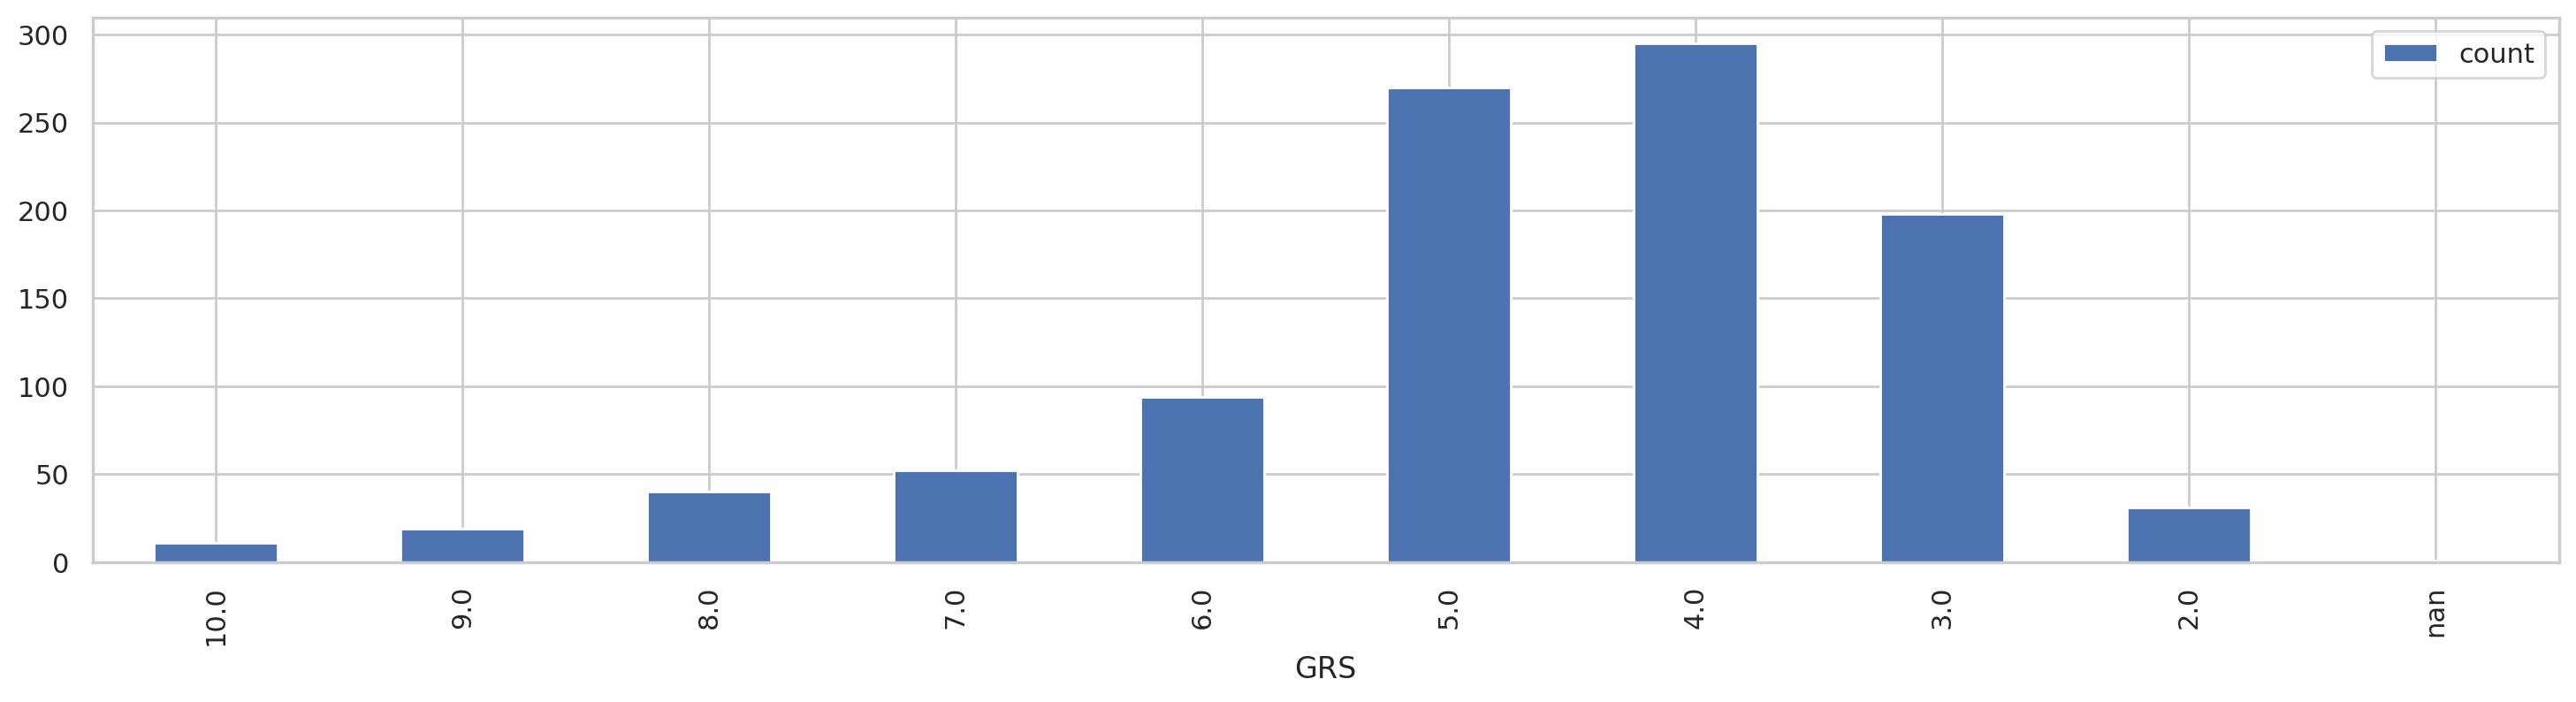

In [27]:
result_df.toPandas().plot.bar(x='GRS');

### 4.2 Summary Statistics:

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [29]:
(housing_df.describe().select(
                    "summary",
                    F.round("GRS", 4).alias("GRS"),
                    F.round("KM", 4).alias("KM"),
                    F.round("KT", 4).alias("KT"),
                    F.round("LT", 4).alias("LT"),
                    F.round("LB", 4).alias("LB"),

                    F.round("HARGA", 4).alias("HARGA"))
                    .show())

+-------+------+--------+--------+-----------------+----+--------+
|summary|   GRS|      KM|      KT|               LT|  LB|   HARGA|
+-------+------+--------+--------+-----------------+----+--------+
|  count|1010.0|  1010.0|  1010.0|           1010.0| 0.0|  1010.0|
|   mean|4.6683|237.4327|276.5396|7.6289870225743E9|NULL|   505.5|
| stddev|1.5728|179.9576|177.8646|7.3409458154675E9|NULL|291.7062|
|    min|   2.0|    25.0|    40.0|            4.3E8|NULL|     1.0|
|    max|  10.0|  1400.0|  1126.0|     6.5000002E10|NULL|  1010.0|
+-------+------+--------+--------+-----------------+----+--------+



## 5. Data Preprocessing




### 5.1 Preprocessing The Target Values


In [30]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("HARGA", col("HARGA")/100000)

In [31]:
# Show the first 2 lines of `df`
housing_df.show(2)

+------+----+-----+-----+-----+----+
| HARGA|  LB|   LT|   KT|   KM| GRS|
+------+----+-----+-----+-----+----+
|  NULL|NULL| NULL| NULL| NULL|NULL|
|1.0E-5|NULL|3.8E9|220.0|220.0| 3.0|
+------+----+-----+-----+-----+----+
only showing top 2 rows



We can clearly see that the values have been adjusted correctly when we look at the result of the show() method:

## 6. Feature Engineering

In [32]:
housing_df.columns

['HARGA', 'LB', 'LT', 'KT', 'KM', 'GRS']

In [33]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("LB")/col("LT"), 2))
                       .withColumn("popperhh", F.round(col("KT")/col("KM"), 2))
                       .withColumn("bdrmsperrm", F.round(col("HARGA")/col("GRS"), 2)))

In [34]:
# Inspect the result
housing_df.show(5)

+------+----+-----+-----+-----+----+--------+--------+----------+
| HARGA|  LB|   LT|   KT|   KM| GRS|rmsperhh|popperhh|bdrmsperrm|
+------+----+-----+-----+-----+----+--------+--------+----------+
|  NULL|NULL| NULL| NULL| NULL|NULL|    NULL|    NULL|      NULL|
|1.0E-5|NULL|3.8E9|220.0|220.0| 3.0|    NULL|     1.0|       0.0|
|2.0E-5|NULL|4.6E9|180.0|137.0| 4.0|    NULL|    1.31|       0.0|
|3.0E-5|NULL|3.0E9|267.0|250.0| 4.0|    NULL|    1.07|       0.0|
|4.0E-5|NULL|4.3E8| 40.0| 25.0| 2.0|    NULL|     1.6|       0.0|
+------+----+-----+-----+-----+----+--------+--------+----------+
only showing top 5 rows



In [35]:
# Re-order and select columns
housing_df = housing_df.select("HARGA",
                              "LB",
                              "KT",
                              "KM",
                              "GRS",
                              "rmsperhh",
                              "popperhh",
                              "bdrmsperrm")

### 6.1 Feature Extraction

Now that we have re-ordered the data, we're ready to normalize the data. We will choose the features to be normalized.

In [36]:
featureCols = ["HARGA", "LB", "KT", "KM", "rmsperhh", "popperhh", "bdrmsperrm"]

**Use a VectorAssembler to put features into a feature vector column:**

In [37]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

In [38]:
assembled_df = assembler.transform(housing_df)

In [41]:
vector_assembler = VectorAssembler(inputCols=featureCols, outputCol="features", handleInvalid="skip")


All the features have transformed into a Dense Vector.

### 6.2 Standardization

Next, we can finally scale the data using `StandardScaler`. The input columns are the `features`, and the output column with the rescaled that will be included in the scaled_df will be named `"features_scaled"`:

In [ ]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [ ]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[129.0,322.0,126....|[0.30623297630686...|
|[1106.0,2401.0,11...|[2.62553233949916...|
|[190.0,496.0,177....|[0.45104081781631...|
|[235.0,558.0,219....|[0.55786627466754...|
|[280.0,565.0,259....|[0.66469173151877...|
|[213.0,413.0,193....|[0.50564049576249...|
|[489.0,1094.0,514...|[1.16083663111672...|
|[687.0,1157.0,647...|[1.63086864126214...|
|[665.0,1206.0,595...|[1.57864286235709...|
|[707.0,1551.0,714...|[1.67834662208491...|
+--------------------+--------------------+
only showing top 10 rows



### 7. Building A Machine Learning Model With Spark ML

With all the preprocessing done, it's finally time to start building our Linear Regression model! Just like always, we first need to split the data into training and test sets. Luckily, this is no issue with the `randomSplit()` method:

In [ ]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

We pass in a list with two numbers that represent the size that we want your training and test sets to have and a seed, which is needed for reproducibility reasons.

**Note** that the argument `elasticNetParam` corresponds to $\alpha$ or the vertical intercept and that the `regParam` or the regularization paramater corresponds to $\lambda$.

In [ ]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

**Create an ElasticNet model:**

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

The objective function to minimize is in this case:
\begin{align}
min_w\frac{1}{2n_{samples}}{\parallel{X_w - y}\parallel}^2_2 + \alpha\lambda{\parallel{X_w - y}\parallel}_1 + \frac{\alpha(1-\lambda)}{2}{\parallel{w}\parallel}^2_2
\end{align}

http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [ ]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv',
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [ ]:
# Fit the data to the model
linearModel = lr.fit(train_data)

## 8. Evaluating the Model

With our model in place, we can generate predictions for our test data: use the `transform()` method to predict the labels for our `test_data`. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

### 8.1 Inspect the Model Co-efficients

In [ ]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.526, 0.0, 0.0, 0.0])

In [ ]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [ ]:
# Intercept for the model
linearModel.intercept

0.989875772139301

In [ ]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [ ]:
coeff_df

,Feature,Co-efficients
0,Intercept,0.989876
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526024
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


### 8.2 Generating Predictions

In [ ]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [ ]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

In [ ]:
predandlabels.show()

+------------------+-----+
|         predmedhv|medhv|
+------------------+-----+
|1.5977678077735522|0.269|
|1.3402962575651638|0.275|
|1.7478926681617617|0.283|
|1.5026315463850333|0.325|
|1.5840068859455108|0.344|
|1.4744173855604754|0.379|
|1.5274954532293994|0.388|
|1.3578228236744827|0.394|
|1.6929041021688493|  0.4|
| 2.010874171848204|  0.4|
|1.3656308740705367| 0.41|
|1.4496919091430263|0.421|
| 1.380970081002033|0.425|
|1.3394379493101451| 0.43|
| 1.722973408950696|0.435|
|1.5529131147882111|0.439|
| 1.323489602290725| 0.44|
|1.4030651812673915|0.444|
|1.5111871672959283|0.446|
|1.5996783060975408| 0.45|
+------------------+-----+
only showing top 20 rows



### 8.3 Inspect the Metrics

Looking at predicted values is one thing, but another and better thing is looking at some metrics to get a better idea of how good your model actually is.

**Using the `LinearRegressionModel.summary` attribute:**

Next, we can also use the `summary` attribute to pull up the `rootMeanSquaredError` and the `r2`.

In [ ]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.8729980899366503


In [ ]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.6714989215155925


In [ ]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.42213332730120356


+ The RMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.

+ The R2 ("R squared") or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits our data.

**Using the RegressionEvaluator from pyspark.ml package:**

In [ ]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.9033627063798556


In [ ]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.6888437385796472


In [ ]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.40877519027090536


**Using the RegressionMetrics from pyspark.mllib package:**

In [ ]:
# mllib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)

In [ ]:
print("RMSE: {0}".format(metrics.rootMeanSquaredError))

RMSE: 0.9033627063798556


In [ ]:
print("MAE: {0}".format(metrics.meanAbsoluteError))

MAE: 0.6888437385796472


In [ ]:
print("R2: {0}".format(metrics.r2))

R2: 0.40877519027090536


There's definitely some improvements needed to our model! If we want to continue with this model, we can play around with the parameters that we passed to your model, the variables that we included in your original DataFrame.

In [ ]:
spark.stop()